# Desafío 4 - Peliculas IMDB

En este desafío el objetivo es encontrar el mejor modelo de machine learning (ML) para predecir el markup (ingresos/presupuesto) para lanzamiento de peliculas nuevas. 
Inicialmente se analizarán los datasets y las posibles variables feature. Luego, con la data limpia, procederemos a utilizar clasificadores más bien débiles como KNN y Regresión Logítica para finalizar con modelos más robustos como lo son Bagging y Boosting. Todo estos modelos serán optimizados gracias a la combinación de pipeline + GridSearch. Para concluir el análisis utlizaremos diversas métricas como matirces de confusion, curva ROC y AUC.


<a id="section_toc"></a> 
## Tabla de Contenidos

<a href="#section_ii">Introducción - Importaciones</a>

<a href="#section_data">Análisis de Datasets</a>

<a href="#section_target">Variable target</a>

<a href="#section_features">Variables Features</a>

   - <a href="#section_nulos">Cantidad de nulos por columna</a>
   
   - <a href="#section_country">Country</a>

   - <a href="#section_date">Date published</a>

   - <a href="#section_participantes">Participantes</a>
   
   - <a href="#section_genero">Género</a>

   - <a href="#section_heatmap">Heatmap</a>

<a href="#section_target_final">Discretización Target</a>

<a href="#section_modelos">Modelos de Clasificación Pipelines</a>

   - <a href="#section_smotenc">SMOTENC</a>
   
   - <a href="#section_knn">KNN</a>

   - <a href="#section_rl">Regresión Logística</a>
   
   - <a href="#section_dt">Decision Trees</a>

   - <a href="#section_random_forest">Random Forest</a>
   
   - <a href="#section_xgb">XGBoost</a>
   
<a href="#section_rc_auc">Roc Curve y AUC</a>
   
<a href="#section_rfe">Recursive Feature Elimination with Cross Validation</a>

<a href="#section_pickle">Pickle</a>


---

<a id="section_ii"></a>

## Introducción - Importaciones

[volver a TOC](#section_toc)

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV 
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import RFECV
from lime.lime_tabular import LimeTabularExplainer
import pickle

<a id="section_data"></a>

## Análisis de Datasets

[volver a TOC](#section_toc)

In [2]:
data_movies = pd.read_csv("IMDb movies.csv")

C:\Users\santi\anaconda3\envs\dhdsblend2021\lib\site-packages\IPython\core\interactiveshell.py:3427: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
data_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85855 entries, 0 to 85854
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_title_id          85855 non-null  object 
 1   title                  85855 non-null  object 
 2   original_title         85855 non-null  object 
 3   year                   85855 non-null  object 
 4   date_published         85855 non-null  object 
 5   genre                  85855 non-null  object 
 6   duration               85855 non-null  int64  
 7   country                85791 non-null  object 
 8   language               85022 non-null  object 
 9   director               85768 non-null  object 
 10  writer                 84283 non-null  object 
 11  production_company     81400 non-null  object 
 12  actors                 85786 non-null  object 
 13  description            83740 non-null  object 
 14  avg_vote               85855 non-null  float64
 15  vo

In [4]:
data_movies.head(5)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0


In [5]:
data_names = pd.read_csv("IMDb names.csv")

In [6]:
data_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297705 entries, 0 to 297704
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   imdb_name_id           297705 non-null  object 
 1   name                   297705 non-null  object 
 2   birth_name             297705 non-null  object 
 3   height                 44681 non-null   float64
 4   bio                    204698 non-null  object 
 5   birth_details          110612 non-null  object 
 6   date_of_birth          110612 non-null  object 
 7   place_of_birth         103992 non-null  object 
 8   death_details          39933 non-null   object 
 9   date_of_death          39933 non-null   object 
 10  place_of_death         37038 non-null   object 
 11  reason_of_death        22694 non-null   object 
 12  spouses_string         45352 non-null   object 
 13  spouses                297705 non-null  int64  
 14  divorces               297705 non-nu

In [7]:
data_names.head(5)

,imdb_name_id,name,birth_name,height,bio,birth_details,date_of_birth,place_of_birth,death_details,date_of_death,place_of_death,reason_of_death,spouses_string,spouses,divorces,spouses_with_children,children
0,nm0000001,Fred Astaire,Frederic Austerlitz Jr.,177.0,"Fred Astaire was born in Omaha, Nebraska, to J...","May 10, 1899 in Omaha, Nebraska, USA",1899-05-10,"Omaha, Nebraska, USA","June 22, 1987 in Los Angeles, California, USA ...",1987-06-22,"Los Angeles, California, USA",pneumonia,Robyn Smith (27 June 1980 - 22 June 1987) (hi...,2,0,1,2
1,nm0000002,Lauren Bacall,Betty Joan Perske,174.0,Lauren Bacall was born Betty Joan Perske on Se...,"September 16, 1924 in The Bronx, New York City...",1924-09-16,"The Bronx, New York City, New York, USA","August 12, 2014 in New York City, New York, US...",2014-08-12,"New York City, New York, USA",stroke,Jason Robards (4 July 1961 - 10 September 196...,2,1,2,3
2,nm0000003,Brigitte Bardot,Brigitte Bardot,166.0,"Brigitte Bardot was born on September 28, 1934...","September 28, 1934 in Paris, France",1934-09-28,"Paris, France",NaN,NaN,NaN,NaN,Bernard d'Ormale (16 August 1992 - present)\n...,4,3,1,1
3,nm0000004,John Belushi,John Adam Belushi,170.0,"John Belushi was born in Chicago, Illinois, US...","January 24, 1949 in Chicago, Illinois, USA",1949-01-24,"Chicago, Illinois, USA","March 5, 1982 in Hollywood, Los Angeles, Calif...",1982-03-05,"Hollywood, Los Angeles, California, USA",acute cocaine and heroin intoxication,Judith Belushi-Pisano (31 December 1976 - 5 M...,1,0,0,0
4,nm0000005,Ingmar Bergman,Ernst Ingmar Bergman,179.0,"Ernst Ingmar Bergman was born July 14, 1918, t...","July 14, 1918 in Uppsala, Uppsala län, Sweden",1918-07-14,"Uppsala, Uppsala län, Sweden","July 30, 2007 in Fårö, Gotlands län, Sweden (...",2007-07-30,"Fårö, Gotlands län, Sweden",natural causes,Ingrid Bergman (11 November 1971 - 20 May 199...,5,4,5,8


In [8]:
data_ratings = pd.read_csv("IMDb ratings.csv")

In [9]:
data_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85855 entries, 0 to 85854
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   imdb_title_id              85855 non-null  object 
 1   weighted_average_vote      85855 non-null  float64
 2   total_votes                85855 non-null  int64  
 3   mean_vote                  85855 non-null  float64
 4   median_vote                85855 non-null  float64
 5   votes_10                   85855 non-null  int64  
 6   votes_9                    85855 non-null  int64  
 7   votes_8                    85855 non-null  int64  
 8   votes_7                    85855 non-null  int64  
 9   votes_6                    85855 non-null  int64  
 10  votes_5                    85855 non-null  int64  
 11  votes_4                    85855 non-null  int64  
 12  votes_3                    85855 non-null  int64  
 13  votes_2                    85855 non-null  int

In [10]:
data_ratings.head(5)

,imdb_title_id,weighted_average_vote,total_votes,mean_vote,median_vote,votes_10,votes_9,votes_8,votes_7,votes_6,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0000009,5.9,154,5.9,6.0,12,4,10,43,28,...,5.7,13.0,4.5,4.0,5.7,34.0,6.4,51.0,6.0,70.0
1,tt0000574,6.1,589,6.3,6.0,57,18,58,137,139,...,6.2,23.0,6.6,14.0,6.4,66.0,6.0,96.0,6.2,331.0
2,tt0001892,5.8,188,6.0,6.0,6,6,17,44,52,...,5.8,4.0,6.8,7.0,5.4,32.0,6.2,31.0,5.9,123.0
3,tt0002101,5.2,446,5.3,5.0,15,8,16,62,98,...,5.5,14.0,6.1,21.0,4.9,57.0,5.5,207.0,4.7,105.0
4,tt0002130,7.0,2237,6.9,7.0,210,225,436,641,344,...,7.3,82.0,7.4,77.0,6.9,139.0,7.0,488.0,7.0,1166.0


In [11]:
data_title_principals = pd.read_csv("IMDb title_principals.csv")

In [12]:
data_title_principals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835513 entries, 0 to 835512
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   imdb_title_id  835513 non-null  object
 1   ordering       835513 non-null  int64 
 2   imdb_name_id   835513 non-null  object
 3   category       835513 non-null  object
 4   job            212731 non-null  object
 5   characters     340836 non-null  object
dtypes: int64(1), object(5)
memory usage: 38.2+ MB


In [13]:
data_title_principals.head(5)

,imdb_title_id,ordering,imdb_name_id,category,job,characters
0,tt0000009,1,nm0063086,actress,NaN,"[""Miss Geraldine Holbrook (Miss Jerry)""]"
1,tt0000009,2,nm0183823,actor,NaN,"[""Mr. Hamilton""]"
2,tt0000009,3,nm1309758,actor,NaN,"[""Chauncey Depew - the Director of the New Yor..."
3,tt0000009,4,nm0085156,director,NaN,NaN
4,tt0000574,1,nm0846887,actress,NaN,"[""Kate Kelly""]"


#### Por lo visto en los datasets tenemos:
- **data_movies**: es el dataset padre, que contiene el "budget" y el "worlwide_gross_income", que en conjunto conformaran la variable target **"markup"** y nuestras principales variables features.
- **data_names**: contiene información sobre participantes de las peliculas, que pueden ser actores, directores, porductores, guinistas, etc.
- **data_ratings**: nos aportas mas informacion sobre las peliculas, aperturando la votaciones en funcion de edad y sexo.
- **data_title_principals**: es la tabla que asigna participantes a peliculas y que nos va a permitir hacer join para crear variables features en el dataset padre.

In [14]:
# Generamos un nuevo dataset dropeando todas las filas que no contienen datos en "budget"
data = data_movies[data_movies.budget.notnull()]
# Dropeamos todas las filas que no contienen datos en "worlwide_gross_income"
data = data[data.worlwide_gross_income.notnull()]
# Dropeamos las peliculas con año de lanzamieno menor a el 2000, asumiendo que son viejas y pueden diferir en las variables features que predicen el markup
data = data[data['year'].values.astype(int) > 2000]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9448 entries, 4334 to 85847
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_title_id          9448 non-null   object 
 1   title                  9448 non-null   object 
 2   original_title         9448 non-null   object 
 3   year                   9448 non-null   object 
 4   date_published         9448 non-null   object 
 5   genre                  9448 non-null   object 
 6   duration               9448 non-null   int64  
 7   country                9447 non-null   object 
 8   language               9415 non-null   object 
 9   director               9446 non-null   object 
 10  writer                 9388 non-null   object 
 11  production_company     9325 non-null   object 
 12  actors                 9446 non-null   object 
 13  description            9290 non-null   object 
 14  avg_vote               9448 non-null   float64
 15  

In [15]:
genre_group = data.groupby('genre').genre.count().sort_values(ascending=False)
genre_group

genre
Drama                       909
Comedy                      649
Comedy, Drama               460
Comedy, Drama, Romance      344
Comedy, Romance             321
                           ... 
Crime, Thriller, Western      1
Action, Thriller, War         1
Drama, Action                 1
Drama, Action, Thriller       1
Action, Drama, Music          1
Name: genre, Length: 485, dtype: int64

In [16]:
language_group = data.groupby('language').language.count().sort_values(ascending=False)
language_group

language
English                             3466
Spanish                              319
French                               317
English, Spanish                     305
Russian                              182
                                    ... 
English, Persian, German, Arabic       1
English, Pawnee, French                1
English, Papiamento                    1
English, Old English                   1
Zulu, Xhosa, Afrikaans, English        1
Name: language, Length: 1494, dtype: int64

<a id="section_target"></a>

## Variable target

[volver a TOC](#section_toc)

In [17]:
data['budget'].head(5)

4334      $ 48000000
30350     $ 22000000
31237    $ 100000000
31242     $ 12000000
31244     $ 35000000
Name: budget, dtype: object

In [18]:
# Separamos la columna por el espacio para poder aperturar el valor y la moneda.
budget_str=data.budget.str
budget_separado = budget_str.split(' ', expand=True)
budget_separado.rename(columns={0:'moneda', 1:'valor'},inplace=True)
budget_separado

,moneda,valor
4334,$,48000000
30350,$,22000000
31237,$,100000000
31242,$,12000000
31244,$,35000000
...,...,...
85826,INR,50000000
85828,INR,30000000
85835,MYR,20000000
85843,INR,240000000


In [19]:
#como se puede observar más del 80% de los registros de budget se conforma con las divisa estadounidense y el euro.
budget_separado['moneda'].value_counts(normalize=True)

$      0.629022
EUR    0.191681
INR    0.035140
GBP    0.021486
NOK    0.012489
CAD    0.010267
AUD    0.008785
BRL    0.008679
DKK    0.006668
CNY    0.005504
RUR    0.005186
TRL    0.005186
SEK    0.004975
EGP    0.004340
PLN    0.004340
KRW    0.004022
FRF    0.004022
HUF    0.003810
HKD    0.003810
CZK    0.003387
JPY    0.002434
MXN    0.002434
THB    0.002223
SGD    0.002117
ZAR    0.001693
ARS    0.001588
NZD    0.001588
UAH    0.001482
MYR    0.001164
TWD    0.001164
DEM    0.001164
FIM    0.000953
ISK    0.000741
CHF    0.000635
PKR    0.000529
DOP    0.000423
IRR    0.000423
PHP    0.000423
BGL    0.000423
LVL    0.000423
ESP    0.000318
IDR    0.000318
ITL    0.000318
EEK    0.000318
RON    0.000212
CLP    0.000212
HRK    0.000106
BDT    0.000106
AMD    0.000106
ILS    0.000106
ATS    0.000106
NLG    0.000106
SKK    0.000106
COP    0.000106
BND    0.000106
NGN    0.000106
LTL    0.000106
VEB    0.000106
YUM    0.000106
AED    0.000106
Name: moneda, dtype: float64

In [20]:
#ahora procedemos a dolarizar todos los registros que estan en euros.

In [21]:
data_euros=data[budget_separado['moneda']=='EUR']

In [22]:
data_euros= data_euros[['year', 'budget']]

In [23]:
data_euros

,year,budget
33738,2001,EUR 7000000
36806,2002,EUR 9500000
37296,2002,EUR 11590000
38596,2002,EUR 40000000
38832,2002,EUR 6000000
...,...,...
85690,2019,EUR 2500000
85691,2019,EUR 9000
85700,2019,EUR 1
85741,2019,EUR 2869000


In [24]:
# Separamos la columna por el espacio para poder aperturar el valor y la moneda.
budget_eur_str=data_euros.budget.str
budget_separado_eur = budget_eur_str.split(' ', expand=True)
budget_separado_eur

,0,1
33738,EUR,7000000
36806,EUR,9500000
37296,EUR,11590000
38596,EUR,40000000
38832,EUR,6000000
...,...,...
85690,EUR,2500000
85691,EUR,9000
85700,EUR,1
85741,EUR,2869000


In [25]:
#Renombramos 
budget_separado_eur.rename(columns={0:'moneda', 1:'valor'},inplace=True)

In [26]:
#Dropeamos los registros 'EUR' para asi quedarnos solo con el valor numérico.
budget_eur= budget_separado_eur.drop(['moneda'], axis=1)

In [27]:
budget_eur

,valor
33738,7000000
36806,9500000
37296,11590000
38596,40000000
38832,6000000
...,...
85690,2500000
85691,9000
85700,1
85741,2869000


In [28]:
data_euros= data_euros.drop('budget', axis=1)

In [29]:
#Creamos un dataframe que contenga el año y los valores en euro de budget.
data_euros=pd.concat([data_euros, budget_eur], axis=1)

In [30]:
data8=data_euros.astype(int)

In [31]:
data8

,year,valor
33738,2001,7000000
36806,2002,9500000
37296,2002,11590000
38596,2002,40000000
38832,2002,6000000
...,...,...
85690,2019,2500000
85691,2019,9000
85700,2019,1
85741,2019,2869000


In [32]:
#En las siguientes líneas de código comprobamos que hayan 1811 registros. Los hay, ok.
data_2000= data8[data8['year'].values==2000]
len(data_2000)

0

In [33]:
data_2001= data8[data8['year'].values==2001]
len(data_2001)

11

In [34]:
data_2002= data8[data8['year'].values==2002]
len(data_2002)

32

In [35]:
data_2003= data8[data8['year'].values==2003]
len(data_2003)

52

In [36]:
data_2004= data8[data8['year'].values==2004]
len(data_2004)


78

In [37]:
data_2005= data8[data8['year'].values==2005]
len(data_2005)

73

In [38]:
data_2006= data8[data8['year'].values==2006]
len(data_2006)

103

In [39]:
data_2007= data8[data8['year'].values==2007]
len(data_2007)

112

In [40]:
data_2008 = data8[data8['year'].values==2008]
len(data_2008)

128

In [41]:
data_2009= data8[data8['year'].values==2009]
len(data_2009)

104

In [42]:
data_2010= data8[data8['year'].values==2010]
len(data_2010)

116

In [43]:
data_2011= data8[data8['year'].values==2011]
len(data_2011)

127

In [44]:
data_2012= data8[data8['year'].values==2012]
len(data_2012)

116

In [45]:
data_2013= data8[data8['year'].values==2013]
len(data_2013)

102

In [46]:
data_2014= data8[data8['year'].values==2014]
len(data_2014)

102

In [47]:
data_2015= data8[data8['year'].values==2015]
len(data_2015)

125

In [48]:
data_2016= data8[data8['year'].values==2016]
len(data_2016)

127

In [49]:
data_2017= data8[data8['year'].values==2017]
len(data_2017)

116

In [50]:
data_2018= data8[data8['year'].values==2018]
len(data_2018)

99

In [51]:
data_2019= data8[data8['year'].values==2019]
len(data_2019)

77

In [52]:
data_2020= data8[data8['year'].values==2020]
len(data_2020)

11

In [53]:
data_2021= data8[data8['year'].values==2021]
len(data_2021)

0

In [54]:
warnings.filterwarnings('ignore')

In [55]:
#Ahora en las siguientes líneas de código transformamos de euro a dolar según el tipo de cambio 
#correspondiente al año de la película. 
data_2001['valor'] = data_2001['valor'].apply(lambda x: x*0.90)

In [56]:
data_2002['valor']= data_2002['valor'].apply(lambda x: x*0.95)

In [57]:
data_2003['valor']= data_2003['valor'].apply(lambda x: x*1.13)

In [58]:
data_2004['valor']= data_2004['valor'].apply(lambda x: x*1.24)

In [59]:
data_2005['valor']= data_2005['valor'].apply(lambda x: x*1.24)

In [60]:
data_2006['valor']= data_2006['valor'].apply(lambda x: x*1.26)

In [61]:
data_2007['valor']= data_2007['valor'].apply(lambda x: x*1.37)

In [62]:
data_2008['valor']= data_2008['valor'].apply(lambda x: x*1.47)

In [63]:
data_2009['valor']= data_2009['valor'].apply(lambda x: x*1.39)

In [64]:
data_2010['valor']= data_2010['valor'].apply(lambda x: x*1.33)

In [65]:
data_2011['valor']= data_2011['valor'].apply(lambda x: x*1.39)

In [66]:
data_2012['valor']= data_2012['valor'].apply(lambda x: x*1.29)

In [67]:
data_2013['valor']= data_2013['valor'].apply(lambda x: x*1.33)

In [68]:
data_2014['valor']= data_2014['valor'].apply(lambda x: x*1.33)

In [69]:
data_2015['valor']= data_2015['valor'].apply(lambda x: x*1.11)

In [70]:
data_2016['valor']= data_2016['valor'].apply(lambda x: x*1.11)

In [71]:
data_2017['valor']= data_2017['valor'].apply(lambda x: x*1.13)

In [72]:
data_2018['valor']= data_2018['valor'].apply(lambda x: x*1.18)

In [73]:
data_2019['valor']= data_2019['valor'].apply(lambda x: x*1.12)

In [74]:
data_2020['valor']= data_2020['valor'].apply(lambda x: x*1.14)

In [75]:
dolarized_eur_budget=pd.concat([data_2001, data_2002, data_2003, data_2004, data_2005, data_2006, data_2007, data_2008,
                               data_2009, data_2010, data_2011, data_2012, data_2013, data_2014, data_2015, data_2016,
                               data_2017, data_2018, data_2019, data_2020])

In [76]:
#Ya tenemos los registros dolarizados.
dolarized_eur_budget

,year,valor
33738,2001,6300000.0
38843,2001,2475000.0
39032,2001,3780000.0
39264,2001,1863000.0
39337,2001,4320000.0
...,...,...
54208,2020,2280000.0
54663,2020,228000.0
81263,2020,2850000.0
85008,2020,11400000.0


In [77]:
df_solo_dolar=data[budget_separado['moneda']=='$']

In [78]:
budget_solo_dolar= df_solo_dolar[['budget']]

In [79]:
budget_solo_dolar

,budget
4334,$ 48000000
30350,$ 22000000
31237,$ 100000000
31242,$ 12000000
31244,$ 35000000
...,...
85477,$ 200000
85530,$ 950000
85592,$ 500000
85740,$ 12000000


In [80]:
# Separamos la columna por el espacio para poder aperturar el valor y la moneda.
budget_dol_str=budget_solo_dolar.budget.str
budget_separado_dol = budget_dol_str.split(' ', expand=True)
budget_separado_dol.rename(columns={0:'moneda', 1:'valor'},inplace=True)
budget_separado_dol

,moneda,valor
4334,$,48000000
30350,$,22000000
31237,$,100000000
31242,$,12000000
31244,$,35000000
...,...,...
85477,$,200000
85530,$,950000
85592,$,500000
85740,$,12000000


In [81]:
# Nos quedamos solo con los valores en dolares
budget_dolar_inicial= budget_separado_dol[['valor']]
budget_dolar_inicial.tail()

,valor
85477,200000
85530,950000
85592,500000
85740,12000000
85756,1200000


In [82]:
# Nos quedamos con los valores del budget que estaban en euro y fueron dolarizados
dolarized_eur_budget= dolarized_eur_budget[['valor']]

In [83]:
# Budget ya esta solo en valor de la moneda estadounidense.
budget_final= pd.concat([budget_dolar_inicial, dolarized_eur_budget], axis=0).sort_index(ascending=True)

In [84]:
data= pd.concat([data, budget_final], axis=1)

In [85]:
# Dejamos la columna "budget_$ y dropeamos "valor"
data['budget_$']= data.valor
data= data.drop(['valor'], axis=1)

In [86]:
wwgi_str=data.worlwide_gross_income.str
wwgi_separado = wwgi_str.split(' ', expand=True)
wwgi_separado.rename(columns={0:'moneda', 1:'valor'},inplace=True)
wwgi_separado

,moneda,valor
4334,$,76019048
30350,$,5271666
31237,$,333535934
31242,$,56298474
31244,$,74558115
...,...,...
85826,$,9306
85828,$,2568
85835,$,83857
85843,$,524061


In [87]:
worldwide_list= data['worlwide_gross_income'].tolist()

In [88]:
# Observamos que todos los registros del ingreso mundial esta dolarizado
pattern= re.compile(r"\$")
len(re.findall(pattern, str(worldwide_list)))

9448

In [89]:
pattern_2= re.compile(r"EUR")
len(re.findall(pattern_2, str(worldwide_list)))

0

In [90]:
data= pd.concat([data, wwgi_separado['valor']], axis=1)
data.rename(columns={'valor':'wwgi_$'},inplace=True)
# Dropeamo los budget que no estan en dolares
data = data[data['budget_$'].notnull()]
data = data.astype({"budget_$": float,"wwgi_$": float})

Finalmente nos quedamos con worldwide que asumimos tien todos valores en dolares y con los valores en dolares de budget para poder conformar nuestra variable target "markup".

In [91]:
data['markup'] = data['wwgi_$']/data['budget_$']
data.head(5)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,budget_$,wwgi_$,markup
4334,tt0035423,Kate & Leopold,Kate & Leopold,2001,2002-03-01,"Comedy, Fantasy, Romance",118,USA,"English, French",James Mangold,...,77852,$ 48000000,$ 47121859,$ 76019048,44.0,341.0,115.0,48000000.0,76019048.0,1.583730
30350,tt0118589,Glitter,Glitter,2001,2001-11-30,"Drama, Music, Romance",104,USA,English,Vondie Curtis-Hall,...,21298,$ 22000000,$ 4274407,$ 5271666,14.0,319.0,75.0,22000000.0,5271666.0,0.239621
31237,tt0120667,I Fantastici 4,Fantastic Four,2005,2005-09-16,"Action, Adventure, Fantasy",106,"USA, Germany",English,Tim Story,...,307944,$ 100000000,$ 154696080,$ 333535934,40.0,1029.0,112.0,100000000.0,333535934.0,3.335359
31242,tt0120679,Frida,Frida,2002,2003-01-17,"Biography, Drama, Romance",123,"Mexico, USA, Canada","English, French, Russian",Julie Taymor,...,79690,$ 12000000,$ 25885000,$ 56298474,61.0,297.0,130.0,12000000.0,56298474.0,4.691540
31244,tt0120681,La vera storia di Jack lo Squartatore,From Hell,2001,2001-12-21,"Horror, Mystery, Thriller",122,"USA, Czech Republic, UK",English,"Albert Hughes, Allen Hughes",...,144714,$ 35000000,$ 31602566,$ 74558115,54.0,556.0,181.0,35000000.0,74558115.0,2.130232


In [92]:
#Hay 2 registros de budget que son 0, generando outliers de valor infinito.
#Procedemos a quedarnos con los budgets mayores a 1000usd (aca tenemos que ver que numero es el indicado)
data = data[data['markup'].values.astype(int) < 50]
data = data[data['budget_$'].values.astype(int) > 1000]

In [93]:
data.markup.describe()

count    7704.000000
mean        1.901574
std         3.508385
min         0.000014
25%         0.118400
50%         0.712943
75%         2.300040
max        49.795259
Name: markup, dtype: float64

<a id="section_features"></a>

## Variables Features

[volver a TOC](#section_toc)

<a id="section_nulos"></a>
### Cantidad de nulos por columna

In [94]:
def freq_na(df, zeros=False):
    miss      = df.isnull().sum(axis=0)
    miss_prop = miss / len(df)
    freq = pd.concat([miss, miss_prop], axis=1)
    freq.columns = ['total', 'proporcion']
    return freq if zeros else freq[freq['total'] > 0].sort_values(by='proporcion',ascending=False)

freq_na(data)

,total,proporcion
metascore,3139,0.407451
usa_gross_income,3057,0.396807
reviews_from_users,366,0.047508
reviews_from_critics,272,0.035306
description,108,0.014019
production_company,70,0.009086
language,31,0.004024
writer,20,0.002596
actors,2,0.000260
country,1,0.000130


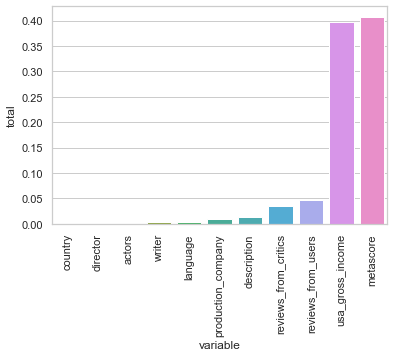

In [95]:
# Graficamos la presencia de nulos para variables de nuestro dataset
def mostrar_nulos(df):
    
    nulos = df.isnull().sum() / len(df)
    nulos = nulos[nulos > 0]
    nulos.sort_values(inplace=True)
    
    nulos = nulos.to_frame()
    nulos.columns = ['total']
    nulos.index.names = ['variable']
    nulos['variable'] = nulos.index
    # ploteo
    sns.set(style="whitegrid", color_codes=True)
    sns.barplot(x='variable', y='total', data=nulos)
    plt.xticks(rotation = 90)
    plt.show()
mostrar_nulos(data)

In [96]:
# Dropeamos metascores y usa_gross_income que contienen mas del 40% de los registros sin datos
data= data.drop(['metascore', 'usa_gross_income'], axis=1)

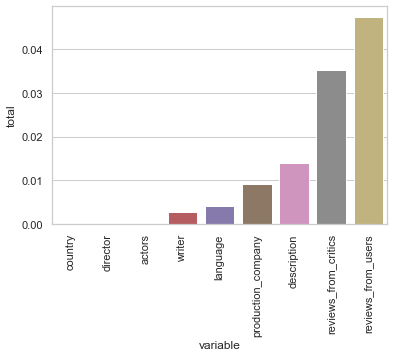

In [97]:
# Graficamos la presencia de nulos para variables de nuestro dataset nuevamente
def mostrar_nulos(df):
    
    nulos = df.isnull().sum() / len(df)
    nulos = nulos[nulos > 0]
    nulos.sort_values(inplace=True)
    
    nulos = nulos.to_frame()
    nulos.columns = ['total']
    nulos.index.names = ['variable']
    nulos['variable'] = nulos.index
    # ploteo
    sns.set(style="whitegrid", color_codes=True)
    sns.barplot(x='variable', y='total', data=nulos)
    plt.xticks(rotation = 90)
    plt.show()
mostrar_nulos(data)

<a id="section_country"></a>

### Country

[volver a TOC](#section_toc)

In [98]:
#Separamos la columna por la ',' para poder aperturarlo.
country_str=data.country.str
country_separado = country_str.split(',', expand=True)
country_separado

,0,1,2,3,4,5,6,7,8,9,10
4334,USA,None,None,None,None,None,None,None,None,None,None
30350,USA,None,None,None,None,None,None,None,None,None,None
31237,USA,Germany,None,None,None,None,None,None,None,None,None
31242,Mexico,USA,Canada,None,None,None,None,None,None,None,None
31244,USA,Czech Republic,UK,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
85691,Germany,None,None,None,None,None,None,None,None,None,None
85740,USA,None,None,None,None,None,None,None,None,None,None
85741,Finland,China,None,None,None,None,None,None,None,None,None
85756,Thailand,None,None,None,None,None,None,None,None,None,None


In [99]:
#Para simplificar decidimos quedarnos con el primer pais
country_separado.rename(columns={0:'first_country'},inplace=True)

In [100]:
country_separado.isnull().sum()

first_country       1
1                4609
2                6375
3                7208
4                7503
5                7621
6                7673
7                7690
8                7699
9                7702
10               7703
dtype: int64

In [101]:
first_country= country_separado.first_country

In [102]:
first_country= pd.DataFrame(first_country)

In [103]:
first_country

,first_country
4334,USA
30350,USA
31237,USA
31242,Mexico
31244,USA
...,...
85691,Germany
85740,USA
85741,Finland
85756,Thailand


In [104]:
# Agregamos el primer pais al dataframe
data=pd.concat([data, first_country], axis=1)

In [105]:
# Dropeamos la columna que contien todos los paises
data= data.drop('country', axis=1)

In [106]:
#Ahora vamos a trabajar sobre la columna first_country
#Vamos a dividir los paises en 3 features: USA, Europa y Others 

In [107]:
cs= data[['first_country']].rename(columns={'first_country':'fc'})

In [108]:
#Hacemos las dummies
cs= pd.get_dummies(cs)

In [109]:
#pd.options.display.max_columns=1000

In [110]:
#Creo una nueva columna que sea la suma de los paises que no sean parte de Europa ni de USA
cs['other_countries']= (cs['fc_Russia']+cs['fc_Canada']+cs['fc_China']+cs['fc_Turkey']
                          +cs['fc_South Korea']+cs['fc_Japan']+cs['fc_Mexico']+cs['fc_India']
                          +cs['fc_Hong Kong']+cs['fc_Argentina']+cs['fc_Australia']+cs['fc_Brazil']
                          +cs['fc_South Africa']+cs['fc_New Zealand']+cs['fc_Chile']+cs['fc_Israel']
                          +cs['fc_Thailand']+cs['fc_Peru']+cs['fc_Taiwan']+cs['fc_Colombia']+cs['fc_Lebanon']
                          +cs['fc_Indonesia']+cs['fc_United Arab Emirates']+cs['fc_Uruguay']+cs['fc_Philippines']
                          +cs['fc_Kazakhstan']+cs['fc_Egypt']+cs['fc_Vietnam']+cs['fc_Venezuela']+cs['fc_Pakistan']
                          +cs['fc_Malaysia']+cs['fc_Palestine']+cs['fc_Georgia']+cs['fc_Iran']+cs['fc_Nigeria']
                          +cs['fc_Panama']+cs['fc_Republic of North Macedonia']+cs['fc_Tunisia']+cs['fc_Iraq']
                          +cs['fc_Puerto Rico']+cs['fc_Singapore']+cs['fc_Aruba']+cs['fc_Bolivia']+cs['fc_Algeria']
                          +cs['fc_Bhutan']+cs['fc_Belarus']+cs['fc_Bangladesh']+cs['fc_Bahamas']+cs['fc_Yemen']
                          +cs['fc_Dominican Republic']+cs['fc_Greenland']+cs['fc_Jordan']+cs['fc_Kenya']+cs['fc_Mali']
                          +cs['fc_Mauritius']+cs['fc_Mongolia']+cs['fc_Montenegro']+cs['fc_Morocco']+cs['fc_Paraguay']
                          +cs['fc_Qatar']+cs['fc_Sri Lanka'])

In [111]:
cs['other_countries'].sum()

1385

In [112]:

cs['USA']= cs['fc_USA']

In [113]:
#creo la columna que contenga las dummies de los paises europeos
cs['Europe']= (cs['fc_France']+cs['fc_UK']+cs['fc_Germany']+cs['fc_Spain']+cs['fc_Finland']+cs['fc_Italy']+cs['fc_Netherlands']+cs['fc_Belgium']+cs['fc_Romania']+cs['fc_Ireland']
               +cs['fc_Hungary']+cs['fc_Portugal']+cs['fc_Austria']+cs['fc_Denmark']+cs['fc_Sweden']+cs['fc_Poland']+cs['fc_Czech Republic']+cs['fc_Bulgaria']+cs['fc_Norway']
              +cs['fc_Iceland']+cs['fc_Serbia']+cs['fc_Ukraine']+cs['fc_Lithuania']+cs['fc_Greece']+cs['fc_Switzerland']+cs['fc_Estonia']+cs['fc_Slovenia']+cs['fc_Lebanon']
               +cs['fc_Luxembourg']+cs['fc_Latvia']+cs['fc_Slovakia']+cs['fc_Bosnia and Herzegovina']+cs['fc_Croatia']+cs['fc_Malta']
              )

In [114]:
countries= cs[['USA', 'Europe', 'other_countries']]

In [115]:
#dropeo una de las 3 columnas para no generar problemas de multicolinealidad y ahorrar costo cumputacional
countries=countries.drop('other_countries', axis=1)

In [116]:
#Uno a al dataframe
data=pd.concat([data, countries], axis=1)

In [117]:
data= data.drop('first_country', axis=1)

<a id="section_date"></a>

### Date published

[volver a TOC](#section_toc)

In [118]:
# Vamos a trabajar sobre la columna date published con el objejtivo de determinar en que mes se estrenó
# Observaremos si influye o no en el exito de la pelicula
date_published_list= data['date_published'].tolist()
pattern = re.compile(r"\d\d\d\d[-/]\d\d[-/]\d\d")
len(re.findall(pattern, str(date_published_list)))


7659

In [119]:
# De otra manera
date_published_str=data.date_published.str
date_published_separado = date_published_str.split('-', expand=True)
date_published_separado.rename(columns={0:'año', 1:'mes', 2:'día'})
date_published_separado

,0,1,2
4334,2002,03,01
30350,2001,11,30
31237,2005,09,16
31242,2003,01,17
31244,2001,12,21
...,...,...,...
85691,2020,07,23
85740,2020,03,19
85741,2019,09,27
85756,2019,03,14


In [120]:
# Buscamos hacer que los registros que vayan de 1-3(winter),4-6(spring),7-9(summer),10-12(autumn) 
df = pd.Series(data['date_published'])
df = pd.to_datetime(df)

season = (df.dt.month - 1) // 3

In [121]:
season += (df.dt.month == 3)&(df.dt.day>=20)
season += (df.dt.month == 6)&(df.dt.day>=21)
season += (df.dt.month == 9)&(df.dt.day>=23)
season -= 3*((df.dt.month == 12)&(df.dt.day>=21)).astype(int)

In [122]:
df

4334    2002-03-01
30350   2001-11-30
31237   2005-09-16
31242   2003-01-17
31244   2001-12-21
           ...    
85691   2020-07-23
85740   2020-03-19
85741   2019-09-27
85756   2019-03-14
85802   2020-02-12
Name: date_published, Length: 7704, dtype: datetime64[ns]

In [123]:
# Dropeamos date_published
data=data.drop('date_published', axis=1)

In [124]:
data=pd.concat([data, season], axis=1)
data.head()

,imdb_title_id,title,original_title,year,genre,duration,language,director,writer,production_company,...,budget,worlwide_gross_income,reviews_from_users,reviews_from_critics,budget_$,wwgi_$,markup,USA,Europe,date_published
4334,tt0035423,Kate & Leopold,Kate & Leopold,2001,"Comedy, Fantasy, Romance",118,"English, French",James Mangold,"Steven Rogers, James Mangold",Konrad Pictures,...,$ 48000000,$ 76019048,341.0,115.0,48000000.0,76019048.0,1.583730,1,0,0.0
30350,tt0118589,Glitter,Glitter,2001,"Drama, Music, Romance",104,English,Vondie Curtis-Hall,"Cheryl L. West, Kate Lanier",Twentieth Century Fox,...,$ 22000000,$ 5271666,319.0,75.0,22000000.0,5271666.0,0.239621,1,0,3.0
31237,tt0120667,I Fantastici 4,Fantastic Four,2005,"Action, Adventure, Fantasy",106,English,Tim Story,"Mark Frost, Michael France",Twentieth Century Fox,...,$ 100000000,$ 333535934,1029.0,112.0,100000000.0,333535934.0,3.335359,1,0,2.0
31242,tt0120679,Frida,Frida,2002,"Biography, Drama, Romance",123,"English, French, Russian",Julie Taymor,"Hayden Herrera, Clancy Sigal",Handprint Entertainment,...,$ 12000000,$ 56298474,297.0,130.0,12000000.0,56298474.0,4.691540,0,0,0.0
31244,tt0120681,La vera storia di Jack lo Squartatore,From Hell,2001,"Horror, Mystery, Thriller",122,English,"Albert Hughes, Allen Hughes","Alan Moore, Eddie Campbell",Twentieth Century Fox,...,$ 35000000,$ 74558115,556.0,181.0,35000000.0,74558115.0,2.130232,1,0,0.0


In [125]:
#Generamos variables dummies a raiz de season.
season_dummies=pd.get_dummies(data['date_published'], drop_first=True)

In [126]:
season_dummies=season_dummies.rename(columns={1:'spring', 2:'summer', 3:'autumn'})

In [127]:
data=pd.concat([data, season_dummies], axis=1)

In [128]:
data= data.drop('date_published', axis=1)

In [129]:
data.head()

,imdb_title_id,title,original_title,year,genre,duration,language,director,writer,production_company,...,reviews_from_users,reviews_from_critics,budget_$,wwgi_$,markup,USA,Europe,spring,summer,autumn
4334,tt0035423,Kate & Leopold,Kate & Leopold,2001,"Comedy, Fantasy, Romance",118,"English, French",James Mangold,"Steven Rogers, James Mangold",Konrad Pictures,...,341.0,115.0,48000000.0,76019048.0,1.583730,1,0,0,0,0
30350,tt0118589,Glitter,Glitter,2001,"Drama, Music, Romance",104,English,Vondie Curtis-Hall,"Cheryl L. West, Kate Lanier",Twentieth Century Fox,...,319.0,75.0,22000000.0,5271666.0,0.239621,1,0,0,0,1
31237,tt0120667,I Fantastici 4,Fantastic Four,2005,"Action, Adventure, Fantasy",106,English,Tim Story,"Mark Frost, Michael France",Twentieth Century Fox,...,1029.0,112.0,100000000.0,333535934.0,3.335359,1,0,0,1,0
31242,tt0120679,Frida,Frida,2002,"Biography, Drama, Romance",123,"English, French, Russian",Julie Taymor,"Hayden Herrera, Clancy Sigal",Handprint Entertainment,...,297.0,130.0,12000000.0,56298474.0,4.691540,0,0,0,0,0
31244,tt0120681,La vera storia di Jack lo Squartatore,From Hell,2001,"Horror, Mystery, Thriller",122,English,"Albert Hughes, Allen Hughes","Alan Moore, Eddie Campbell",Twentieth Century Fox,...,556.0,181.0,35000000.0,74558115.0,2.130232,1,0,0,0,0


<a id="section_participantes"></a>

### Participantes

[volver a TOC](#section_toc)

In [130]:
# Generamos dataframe enlace entre pelicula y sus participantes
data_join = pd.merge(data_title_principals, data_movies, on="imdb_title_id",how='left')
data_join = data_join.drop(['job','characters','title','original_title','date_published','genre','duration','country','language','director','writer','production_company','actors',
                             'description','budget','usa_gross_income','worlwide_gross_income','metascore','reviews_from_users','reviews_from_critics'], axis=1)
data_join.head(5)

,imdb_title_id,ordering,imdb_name_id,category,year,avg_vote,votes
0,tt0000009,1,nm0063086,actress,1894,5.9,154.0
1,tt0000009,2,nm0183823,actor,1894,5.9,154.0
2,tt0000009,3,nm1309758,actor,1894,5.9,154.0
3,tt0000009,4,nm0085156,director,1894,5.9,154.0
4,tt0000574,1,nm0846887,actress,1906,6.1,589.0


In [131]:
data_join.info(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 835513 entries, 0 to 835512
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   imdb_title_id  835513 non-null  object 
 1   ordering       835513 non-null  int64  
 2   imdb_name_id   835513 non-null  object 
 3   category       835513 non-null  object 
 4   year           835494 non-null  object 
 5   avg_vote       835494 non-null  float64
 6   votes          835494 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 51.0+ MB


In [132]:
# Dropeamos las filas con registros vacios
data_join = data_join.dropna(axis = 0)

In [133]:
# Generamos columna con la sumaroria de votos
data_join["sum_votes"] = data_join["avg_vote"]*data_join["votes"]
data_join.head(5)

,imdb_title_id,ordering,imdb_name_id,category,year,avg_vote,votes,sum_votes
0,tt0000009,1,nm0063086,actress,1894,5.9,154.0,908.6
1,tt0000009,2,nm0183823,actor,1894,5.9,154.0,908.6
2,tt0000009,3,nm1309758,actor,1894,5.9,154.0,908.6
3,tt0000009,4,nm0085156,director,1894,5.9,154.0,908.6
4,tt0000574,1,nm0846887,actress,1906,6.1,589.0,3592.9


In [134]:
# Generamos dataframe enlace entre pelicula de data y sus participantes
data_join_peliculas = pd.merge(data_join, data['imdb_title_id'], on="imdb_title_id",how='right')
data_join_peliculas.head(5)

,imdb_title_id,ordering,imdb_name_id,category,year,avg_vote,votes,sum_votes
0,tt0035423,1,nm0000212,actress,2001,6.4,77852.0,498252.8
1,tt0035423,2,nm0413168,actor,2001,6.4,77852.0,498252.8
2,tt0035423,3,nm0000630,actor,2001,6.4,77852.0,498252.8
3,tt0035423,4,nm0005227,actor,2001,6.4,77852.0,498252.8
4,tt0035423,5,nm0003506,director,2001,6.4,77852.0,498252.8


In [135]:
data_join_peliculas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76311 entries, 0 to 76310
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   imdb_title_id  76311 non-null  object 
 1   ordering       76311 non-null  int64  
 2   imdb_name_id   76311 non-null  object 
 3   category       76311 non-null  object 
 4   year           76311 non-null  object 
 5   avg_vote       76311 non-null  float64
 6   votes          76311 non-null  float64
 7   sum_votes      76311 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 5.2+ MB


In [136]:
# Obtenemos los participantes sin repeticiones
data_participantes = data_join_peliculas
data_participantes = data_participantes.drop_duplicates(subset=["imdb_name_id"], keep="first")
data_participantes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40052 entries, 0 to 76310
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   imdb_title_id  40052 non-null  object 
 1   ordering       40052 non-null  int64  
 2   imdb_name_id   40052 non-null  object 
 3   category       40052 non-null  object 
 4   year           40052 non-null  object 
 5   avg_vote       40052 non-null  float64
 6   votes          40052 non-null  float64
 7   sum_votes      40052 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 2.8+ MB


In [137]:
# Generamos dataframe enlace con las participaciones de los participantes de las peliculas que selccionamos
data_join_participantes = pd.merge(data_join, data_participantes['imdb_name_id'], on="imdb_name_id",how='right')
data_join_participantes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239008 entries, 0 to 239007
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   imdb_title_id  239008 non-null  object 
 1   ordering       239008 non-null  int64  
 2   imdb_name_id   239008 non-null  object 
 3   category       239008 non-null  object 
 4   year           239008 non-null  object 
 5   avg_vote       239008 non-null  float64
 6   votes          239008 non-null  float64
 7   sum_votes      239008 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 16.4+ MB


In [138]:
# Reemplazamos "TV Movie 2019" por 2019 para que no quede ningun año con letras
data_join_participantes = data_join_participantes.replace("TV Movie 2019", 2019)
# Ponemos int como formato en la coumna "year"
data_join_participantes = data_join_participantes.astype({"year": int})
# Creamos Pivot Table con la cantidad de votos recibido por participante en distintos años, por la cantidad de votos de las peliculas en las que participo
pivot_table_votes = data_join_participantes.pivot_table('votes', index='imdb_name_id', columns='year',aggfunc=np.sum)
# Creamos Pivot Table que remplaza los nan por ceros
votes_sin_nan = pivot_table_votes.fillna(0)
# Creamos Pivot Table que luego va a contener en cada año el acumulado de votos para cada participante de años anteriores
acumulates_votes = votes_sin_nan
# Desechamos los años que no nos interesa tener informacion de acumulacion de votos a años anteriores
acumulates_votes = acumulates_votes.drop([1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,
                                          1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,
                                          1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,
                                          1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999], axis=1)
acumulates_votes.head(5)

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
imdb_name_id,,,,,,,,,,,,,,,,,,,,,
nm0000002,0.0,0.0,0.0,134971.0,34274.0,0.0,0.0,5171.0,0.0,0.0,...,0.0,4411.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nm0000008,0.0,119173.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nm0000025,121916.0,144777.0,174104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nm0000032,0.0,7731.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nm0000035,352439.0,1082839.0,0.0,134678.0,543020.0,249822.0,309629.0,13505.0,185838.0,1101160.0,...,11078.0,4488.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
# Ganeramos Pivot Table para obtener el acumulado de votos para cada participante en años anteriores al 2000
votes_hasta_2000 = votes_sin_nan.drop([2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020], axis=1)
votes_hasta_2000.loc[:,'Total'] = votes_hasta_2000.sum(numeric_only=True, axis=1)
# Obtenemos la cantidad de votos por participantes en todas la peliculas anteriores al año 2000
acumulates_votes[2000] = votes_hasta_2000['Total']
# Generamos el dataframe con la cantidad acmulada de votos por participantes en todas la peliculas anteriores al año que se indica
for x in range(2001, 2021):
    acumulates_votes[x] = acumulates_votes[x-1] + votes_sin_nan[x]
acumulates_votes.head(5)

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
imdb_name_id,,,,,,,,,,,,,,,,,,,,,
nm0000002,321854.0,321854.0,321854.0,456825.0,491099.0,491099.0,491099.0,496270.0,496270.0,496270.0,...,496270.0,500681.0,500681.0,500681.0,500681.0,500681.0,500681.0,500681.0,500681.0,500681.0
nm0000008,2863555.0,2982728.0,2982728.0,2982728.0,2982728.0,2982728.0,2982728.0,2982728.0,2982728.0,2982728.0,...,2982728.0,2982728.0,2982728.0,2982728.0,2982728.0,2982728.0,2982728.0,2982728.0,2982728.0,2982728.0
nm0000025,4241057.0,4385834.0,4559938.0,4559938.0,4559938.0,4559938.0,4559938.0,4559938.0,4559938.0,4559938.0,...,4559938.0,4559938.0,4559938.0,4559938.0,4559938.0,4559938.0,4559938.0,4559938.0,4559938.0,4559938.0
nm0000032,791171.0,798902.0,798902.0,799102.0,799102.0,799102.0,799102.0,799102.0,799102.0,799102.0,...,799102.0,799102.0,799102.0,799102.0,799102.0,799102.0,799102.0,799102.0,799102.0,799102.0
nm0000035,3314844.0,4397683.0,4397683.0,4532361.0,5075381.0,5325203.0,5634832.0,5648337.0,5834175.0,6935335.0,...,6946413.0,6950901.0,6950901.0,6950901.0,6950901.0,6950901.0,6950901.0,6950901.0,6950901.0,6950901.0


In [140]:
# Ponemos int como formato en la coumna "year"
data_join_peliculas = data_join_peliculas.astype({"year": int})
# Generamos dummies para poder agregar la cantidad de votos acumulados correspondientes a cada participante en el año que corresponda a cada pelicula
dummies_years_data_join_peliculas = pd.get_dummies(data_join_peliculas['year'], drop_first=False)
# Obtenemos la tabla a utilizar para poder agregar la informacion correpondiente a la cantidad de votos acumulados
acumulates_votes2 = pd.merge(data_join_peliculas['imdb_name_id'], acumulates_votes, on="imdb_name_id",how='left')
# Generamos tabla para hacer el join con "data_join_peliculas" con la informacion correpondiente a la cantidad de votos acumulados
votos_acumulados_anteriores = dummies_years_data_join_peliculas
# Multiplicamos las dummies del año de la pelicula con "acumulates_votes2" para obtener el valor correspondiente en la tabla data_join_peliculas
for x in range(2001, 2021):
    votos_acumulados_anteriores[x] = dummies_years_data_join_peliculas[x]*acumulates_votes2[x]
votos_acumulados_anteriores.loc[:,'Total'] = votos_acumulados_anteriores.sum(numeric_only=True, axis=1)
votos_acumulados_anteriores.head(5)

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Total
0,1217068.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1217068.0
1,278029.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,278029.0
2,193238.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,193238.0
3,195033.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,195033.0
4,369672.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,369672.0


In [141]:
# Agregamos el acumulado de cantidad de votos en años anteriores de participantes a "data_join_peliculas" 
data_join_peliculas['acu_votes'] = votos_acumulados_anteriores['Total']
data_join_peliculas.head(5)

,imdb_title_id,ordering,imdb_name_id,category,year,avg_vote,votes,sum_votes,acu_votes
0,tt0035423,1,nm0000212,actress,2001,6.4,77852.0,498252.8,1217068.0
1,tt0035423,2,nm0413168,actor,2001,6.4,77852.0,498252.8,278029.0
2,tt0035423,3,nm0000630,actor,2001,6.4,77852.0,498252.8,193238.0
3,tt0035423,4,nm0005227,actor,2001,6.4,77852.0,498252.8,195033.0
4,tt0035423,5,nm0003506,director,2001,6.4,77852.0,498252.8,369672.0


In [142]:
# Creamos Pivot Table con la sumatoria de votos recibido por participante en distintos años, por la sumatoria de votos de las peliculas en las que participo
pivot_table_sum_votes = data_join_participantes.pivot_table('sum_votes', index='imdb_name_id', columns='year',aggfunc=np.sum)
# Creamos Pivot Table que remplaza los nan por ceros
sum_votes_sin_nan = pivot_table_sum_votes.fillna(0)
# Creamos Pivot Table que luego va a contener en cada año la sumatoria de votos para cada participante de años anteriores
acumulates_sum_votes = sum_votes_sin_nan
# Desechamos los años que no nos interesa tener informacion de acumulacion de votos a años anteriores
acumulates_sum_votes = acumulates_sum_votes.drop([1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,
                                          1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,
                                          1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,
                                          1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999], axis=1)
acumulates_sum_votes.head(5)

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
imdb_name_id,,,,,,,,,,,,,,,,,,,,,
nm0000002,0.0,0.0,0.0,1079768.0,209071.4,0.0,0.0,29991.8,0.0,0.0,...,0.0,23819.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nm0000008,0.0,810376.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nm0000025,707112.8,968470.8,1114265.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nm0000032,0.0,36335.7,0.0,1320.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nm0000035,2215922.4,8715951.4,0.0,954786.6,3821077.8,1617314.0,2377659.8,85081.5,1449536.4,8589048.0,...,74222.6,29620.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [143]:
# Ganeramos Pivot Table para obtener la sumatoria de votos para cada participante en años anteriores al 2000
sum_votes_hasta_2000 = sum_votes_sin_nan.drop([2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020], axis=1)
sum_votes_hasta_2000.loc[:,'Total'] = sum_votes_hasta_2000.sum(numeric_only=True, axis=1)
# Obtenemos la sumatoria de votos por participantes en todas la peliculas anteriores al año 2000
acumulates_sum_votes[2000] = sum_votes_hasta_2000['Total']
# Generamos el dataframe con la sumatoria acmulada de votos por participantes en todas la peliculas anteriores al año que se indica
for x in range(2001, 2021):
    acumulates_sum_votes[x] = acumulates_sum_votes[x-1] + sum_votes_sin_nan[x]
acumulates_sum_votes.head(5)

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
imdb_name_id,,,,,,,,,,,,,,,,,,,,,
nm0000002,2389394.7,2389394.7,2389394.7,3469162.7,3678234.1,3678234.1,3678234.1,3708225.9,3708225.9,3708225.9,...,3708225.9,3732045.3,3732045.3,3732045.3,3732045.3,3732045.3,3732045.3,3732045.3,3732045.3,3732045.3
nm0000008,24505616.1,25315992.5,25315992.5,25315992.5,25315992.5,25315992.5,25315992.5,25315992.5,25315992.5,25315992.5,...,25315992.5,25315992.5,25315992.5,25315992.5,25315992.5,25315992.5,25315992.5,25315992.5,25315992.5,25315992.5
nm0000025,29659118.8,30627589.6,31741855.2,31741855.2,31741855.2,31741855.2,31741855.2,31741855.2,31741855.2,31741855.2,...,31741855.2,31741855.2,31741855.2,31741855.2,31741855.2,31741855.2,31741855.2,31741855.2,31741855.2,31741855.2
nm0000032,6005780.3,6042116.0,6042116.0,6043436.0,6043436.0,6043436.0,6043436.0,6043436.0,6043436.0,6043436.0,...,6043436.0,6043436.0,6043436.0,6043436.0,6043436.0,6043436.0,6043436.0,6043436.0,6043436.0,6043436.0
nm0000035,24868788.8,33584740.2,33584740.2,34539526.8,38360604.6,39977918.6,42355578.4,42440659.9,43890196.3,52479244.3,...,52553466.9,52583087.7,52583087.7,52583087.7,52583087.7,52583087.7,52583087.7,52583087.7,52583087.7,52583087.7


In [144]:
# Volvemos a utilizar los años en dummies
dummies_years_data_join_peliculas = pd.get_dummies(data_join_peliculas['year'], drop_first=False)
# Obtenemos la tabla a utilizar para poder agregar la informacion correpondiente a la smatoria de votos acumulados
acumulates_sum_votes2 = pd.merge(data_join_peliculas['imdb_name_id'], acumulates_sum_votes, on="imdb_name_id",how='left')
# Generamos tabla para hacer el join con "data_join_peliculas" con la informacion correpondiente a la sumatoria de votos acumulados
sum_votos_acumulados_anteriores = dummies_years_data_join_peliculas
# Multiplicamos las dummies del año de la pelicula con "acumulates_sum_votes2" para obtener el valor correspondiente en la tabla data_join_peliculas
for x in range(2001, 2021):
    sum_votos_acumulados_anteriores[x] = dummies_years_data_join_peliculas[x]*acumulates_sum_votes2[x]
sum_votos_acumulados_anteriores.loc[:,'Total'] = sum_votos_acumulados_anteriores.sum(numeric_only=True, axis=1)
sum_votos_acumulados_anteriores.head(5)

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Total
0,8294364.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8294364.8
1,1790128.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1790128.5
2,1330998.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1330998.9
3,1250233.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1250233.2
4,2566928.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2566928.4


In [145]:
# Agregamos el acumulado de sumatoria de votos en años anteriores de participantes a "data_join_peliculas" 
data_join_peliculas['acu_sum_votes'] = sum_votos_acumulados_anteriores['Total']
# Obtenemos la votacion promedio de peliculas de años anteriores para los participantes 
data_join_peliculas['acu_avg_votes'] = data_join_peliculas['acu_sum_votes']/data_join_peliculas['acu_votes']
data_join_peliculas.head(5)

,imdb_title_id,ordering,imdb_name_id,category,year,avg_vote,votes,sum_votes,acu_votes,acu_sum_votes,acu_avg_votes
0,tt0035423,1,nm0000212,actress,2001,6.4,77852.0,498252.8,1217068.0,8294364.8,6.815038
1,tt0035423,2,nm0413168,actor,2001,6.4,77852.0,498252.8,278029.0,1790128.5,6.438639
2,tt0035423,3,nm0000630,actor,2001,6.4,77852.0,498252.8,193238.0,1330998.9,6.887874
3,tt0035423,4,nm0005227,actor,2001,6.4,77852.0,498252.8,195033.0,1250233.2,6.410367
4,tt0035423,5,nm0003506,director,2001,6.4,77852.0,498252.8,369672.0,2566928.4,6.943800


In [146]:
# Observamos las categoria y cantidad de registros par los participantes 
category_group = data_join_peliculas.groupby('category').category.count().sort_values(ascending=False)
category_group

category
actor                  19468
producer               14013
writer                 12332
actress                11539
director                7997
composer                4976
cinematographer         3405
editor                  1907
production_designer      636
self                      30
archive_footage            7
archive_sound              1
Name: category, dtype: int64

In [147]:
# Obtenemos para las peliculas seleccionadas, cuantas tienen almenos un actor, director, productor o guionistaprint('De las',data.shape[0],'peliculas que seleccionamos:')
mask_actor = data_join_peliculas['category'] == 'actor'
mask_actress = data_join_peliculas['category'] == 'actress'
mask_actor_or_actress = mask_actress|mask_actor
actors = data_join_peliculas[mask_actor]
actress = data_join_peliculas[mask_actress]
actors_or_actress = data_join_peliculas[mask_actor_or_actress]
actors_or_actress_peliculas_unicas = actors_or_actress.drop_duplicates(subset=["imdb_title_id"], keep="first")
print('Hay',actors_or_actress_peliculas_unicas.shape[0],'que contienen informacion sobre su/s actor/es')
producers = data_join_peliculas[data_join_peliculas['category'] == 'producer']
producers_peliculas_unicas = producers.drop_duplicates(subset=["imdb_title_id"], keep="first")
print('Hay',producers_peliculas_unicas.shape[0],'que contienen informacion sobre su/s productor/es')
writers = data_join_peliculas[data_join_peliculas['category'] == 'writer']
writers_peliculas_unicas = writers.drop_duplicates(subset=["imdb_title_id"], keep="first")
print('Hay',writers_peliculas_unicas.shape[0],'que contienen informacion sobre su/s guinista/s')
directors = data_join_peliculas[data_join_peliculas['category'] == 'director']
directors_peliculas_unicas = directors.drop_duplicates(subset=["imdb_title_id"], keep="first")
print('Hay',directors_peliculas_unicas.shape[0],'que contienen informacion sobre su/s director/es')

Hay 7700 que contienen informacion sobre su/s actor/es
Hay 6755 que contienen informacion sobre su/s productor/es
Hay 5970 que contienen informacion sobre su/s guinista/s
Hay 7401 que contienen informacion sobre su/s director/es


In [148]:
# Generamos la suma de votos acumulados de todo el elenco para cada pelicula
actors_acu_votes_group = actors_or_actress.groupby('imdb_title_id').acu_votes.sum()
# Generamos la suma de la sumatoria de votos acumulados de todo el elenco para cada pelicula
actors_acu_sum_votes_group = actors_or_actress.groupby('imdb_title_id').acu_sum_votes.sum()
# Generamos una variable con la cantidad de acotres y actrices para cada pelicula
cant_actor_and_actress_group = actors_or_actress.groupby('imdb_title_id').imdb_name_id.count()
# Generamos una variable con la cantidad de acotrespara cada pelicula
cant_actors_group = actors.groupby('imdb_title_id').imdb_name_id.count()
# Generamos una variable con la cantidad de actrices para cada pelicula
cant_actress_group = actress.groupby('imdb_title_id').imdb_name_id.count()

In [149]:
# Agregamos a nuestro dataframe data la suma de la cantidad de votos anteriores correspondiente al elenco y desechamos las peliculas que no contienen informacion
data = pd.merge(data, actors_acu_votes_group, on="imdb_title_id",how='inner')
data.rename(columns={'acu_votes':'acu_votes_actors'},inplace=True)
# Agregamos la suma de la sumatoria de votos anteriores correspondiente al elenco 
data = pd.merge(data, actors_acu_sum_votes_group, on="imdb_title_id",how='left')
data.rename(columns={'acu_sum_votes':'acu_sum_votes_actors'},inplace=True)
# Agregamos una variable con el voto promedios de todos los votos acumulados de peliculas en las que participo el elenco
data['avg_acu_votes_actors'] = data['acu_sum_votes_actors']/data['acu_votes_actors']
# Agregamos la cantidad de actores y actrices del elenco en cada pelicula
data = pd.merge(data, cant_actor_and_actress_group, on="imdb_title_id",how='left')
data.rename(columns={'imdb_name_id':'cant_elenco'},inplace=True)
# Agregamos la cantidad de actores del elenco en cada pelicula
data = pd.merge(data, cant_actors_group, on="imdb_title_id",how='left')
data.rename(columns={'imdb_name_id':'actores'},inplace=True)
# Agregamos la cantidad de actrices del elenco en cada pelicula
data = pd.merge(data, cant_actress_group, on="imdb_title_id",how='left')
data.rename(columns={'imdb_name_id':'actrices'},inplace=True)
# Agregamos el ratio de mujeres en el elenco en cada pelicula
data['mujeres_elenco'] = data['actrices']/data['cant_elenco'] 
data.mujeres_elenco.fillna(0, inplace = True)

In [150]:
# Generamos la suma de votos acumulados de todos los directores para cada pelicula
directors_acu_votes_group = directors.groupby('imdb_title_id').acu_votes.sum()
# Generamos la suma de la sumatoria de votos acumulados de todos los directores para cada pelicula
directors_acu_sum_votes_group = directors.groupby('imdb_title_id').acu_sum_votes.sum()
# Generamos una variable con la cantidad de directores para cada pelicula
cant_directors_group = directors.groupby('imdb_title_id').imdb_name_id.count()

In [151]:
# Agregamos a nuestro dataframe data la suma de la cantidad de votos anteriores correspondiente a directores y desechamos las peliculas que no contienen informacion
data = pd.merge(data, directors_acu_votes_group, on="imdb_title_id",how='inner')
data.rename(columns={'acu_votes':'acu_votes_directors'},inplace=True)
# Agregamos la suma de la sumatoria de votos anteriores correspondiente a los directores
data = pd.merge(data, directors_acu_sum_votes_group, on="imdb_title_id",how='left')
data.rename(columns={'acu_sum_votes':'acu_sum_votes_directors'},inplace=True)
# Agregamos una variable con el voto promedios de todos los votos acumulados de peliculas en las que participo algun director
data['avg_acu_votes_directors'] = data['acu_sum_votes_directors']/data['acu_votes_directors']
# Agregamos la cantidad de directores en cada pelicula
data = pd.merge(data, cant_directors_group, on="imdb_title_id",how='left')
data.rename(columns={'imdb_name_id':'cant_directores'},inplace=True)

In [152]:
data = data.drop(['acu_sum_votes_actors','actores','actrices','acu_sum_votes_directors'], axis=1)
data.head(5)

,imdb_title_id,title,original_title,year,genre,duration,language,director,writer,production_company,...,spring,summer,autumn,acu_votes_actors,avg_acu_votes_actors,cant_elenco,mujeres_elenco,acu_votes_directors,avg_acu_votes_directors,cant_directores
0,tt0035423,Kate & Leopold,Kate & Leopold,2001,"Comedy, Fantasy, Romance",118,"English, French",James Mangold,"Steven Rogers, James Mangold",Konrad Pictures,...,0,0,0,1883368.0,6.725040,4,0.25,369672.0,6.943800,1
1,tt0118589,Glitter,Glitter,2001,"Drama, Music, Romance",104,English,Vondie Curtis-Hall,"Cheryl L. West, Kate Lanier",Twentieth Century Fox,...,0,0,1,91428.0,2.429943,4,0.50,36255.0,4.109039,1
2,tt0120667,I Fantastici 4,Fantastic Four,2005,"Action, Adventure, Fantasy",106,English,Tim Story,"Mark Frost, Michael France",Twentieth Century Fox,...,0,1,0,2536021.0,6.451394,4,0.25,376543.0,5.620098,1
3,tt0120679,Frida,Frida,2002,"Biography, Drama, Romance",123,"English, French, Russian",Julie Taymor,"Hayden Herrera, Clancy Sigal",Handprint Entertainment,...,0,0,0,1248558.0,6.681328,4,0.50,99121.0,7.341190,1
4,tt0120681,La vera storia di Jack lo Squartatore,From Hell,2001,"Horror, Mystery, Thriller",122,English,"Albert Hughes, Allen Hughes","Alan Moore, Eddie Campbell",Twentieth Century Fox,...,0,0,0,4324996.0,7.288223,4,0.25,429042.0,6.973805,2


#### Distribucion de avg_acu_votes_actors

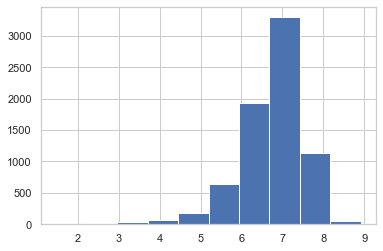

In [153]:
fig_restore = plt.figure()
ax_restore = plt.axes()
ax_restore.hist(data.avg_acu_votes_actors);

#### Distribucion de avg_acu_votes_directors

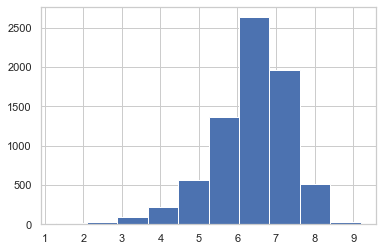

In [154]:
fig_restore = plt.figure()
ax_restore = plt.axes()
ax_restore.hist(data.avg_acu_votes_directors);

#### Distribucion de acu_votes_actors

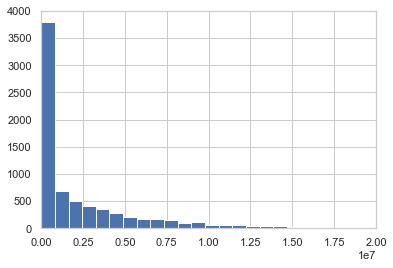

In [155]:
fig_restore = plt.figure()
ax_restore = plt.axes()
plt.xlim(xmin=0, xmax =20000000)
plt.ylim(ymin=0, ymax = 4000)
ax_restore.hist(data.acu_votes_actors, bins=40);

#### Distribucion de acu_votes_directors

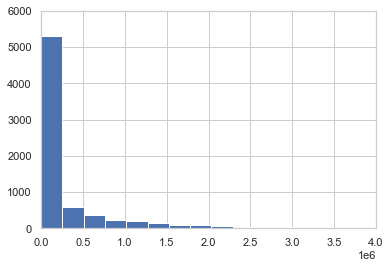

In [156]:
fig_restore = plt.figure()
ax_restore = plt.axes()
plt.xlim(xmin=0, xmax =4000000)
plt.ylim(ymin=0, ymax = 6000)
ax_restore.hist(data.acu_votes_directors, bins=50);

<a id="section_genero"></a>

### Genero

[volver a TOC](#section_toc)

In [157]:
#Trabajmos sobre la feature genre. 
genre_str=data.genre.str
genre_separado = genre_str.split(',', expand=True)

In [158]:
genre_separado

,0,1,2
0,Comedy,Fantasy,Romance
1,Drama,Music,Romance
2,Action,Adventure,Fantasy
3,Biography,Drama,Romance
4,Horror,Mystery,Thriller
...,...,...,...
7394,Drama,None,None
7395,Biography,Drama,Music
7396,Comedy,Drama,None
7397,Drama,Horror,Romance


In [159]:
genre_separado.rename(columns={0:'first_genre'}, inplace=True)

In [160]:
#nos quedamos con los primeros generos
genre_separado= genre_separado.first_genre

In [161]:
#A pesar de que hay peliculas que cuentan con más de un género, se cumple la lógica de cuales son los géneros más populares.
#Comedy, Drama y Action abarcan el 70% de los registros.
genre_separado.value_counts(normalize=True)

Comedy       0.256656
Drama        0.246114
Action       0.202325
Crime        0.065955
Biography    0.055683
Animation    0.053386
Horror       0.047169
Adventure    0.045952
Thriller     0.007569
Fantasy      0.005001
Family       0.003784
Mystery      0.003784
Romance      0.002433
Sci-Fi       0.001352
Musical      0.000811
History      0.000541
Music        0.000541
War          0.000541
Sport        0.000270
Western      0.000135
Name: first_genre, dtype: float64

In [162]:
#Generamos las dummies
genre_dummy= pd.get_dummies(genre_separado)

In [163]:
#Creamos una nueva variable que sea la combinacion del 30% del total, formado por los generos menos populares.
genre_dummy['others_genres']= genre_dummy['Crime'] + genre_dummy['Biography'] + genre_dummy['Animation'] + genre_dummy['Horror'] + genre_dummy['Adventure'] + genre_dummy['Thriller'] + genre_dummy['Fantasy'] + genre_dummy['Family']+genre_dummy['Mystery'] + genre_dummy['Romance'] + genre_dummy['Sci-Fi']+ genre_dummy['Musical'] + genre_dummy['Music'] + genre_dummy['War'] + genre_dummy['History'] + genre_dummy['Sport'] + genre_dummy['Western']

In [164]:
#Dropeamos los géneros que conforman ahora la columna 'others_genres'.
genre_dummy= genre_dummy.drop(['Crime', 'Biography', 'Animation', 'Horror', 'Adventure', 'Thriller', 'Fantasy',
                               'Family', 'Mystery', 'Romance', 'Sci-Fi', 'Musical', 'Music', 'War', 'History', 'Sport', 'Western'], axis=1)

In [165]:
#Nos fijamos que se siga cumpliendo la misma proporcion vista antes.
genre_dummy.Comedy.sum()

1899

In [166]:
genre_dummy.Action.sum()

1497

In [167]:
genre_dummy.Drama.sum()

1821

In [168]:
genre_dummy.others_genres.sum()

2182

In [169]:
#dropeamos la primer columna para no tener luego problema de multicolinealidad.
genre_dummy=genre_dummy.drop(['Action'], axis=1)

In [170]:
#Unimos lo trabajado en la feature 'Genre' al dataframe original.
data= pd.concat([data, genre_dummy], axis=1)

#### Volvemos a fijarnos la proporción de nulos de nuestras features.

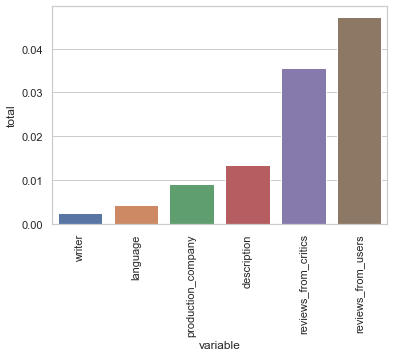

In [171]:
def mostrar_nulos(df):
    
    nulos = df.isnull().sum() / len(df)
    nulos = nulos[nulos > 0]
    nulos.sort_values(inplace=True)
    
    nulos = nulos.to_frame()
    nulos.columns = ['total']
    nulos.index.names = ['variable']
    nulos['variable'] = nulos.index
    # ploteo
    sns.set(style="whitegrid", color_codes=True)
    sns.barplot(x='variable', y='total', data=nulos)
    plt.xticks(rotation = 90)
    plt.show()
mostrar_nulos(data)

<a id="section_heatmap"></a>

### Heatmap

[volver a TOC](#section_toc)

In [172]:
#Dropeamos las variables que no formarán parte de nuestros modelos.
data=data.drop(['reviews_from_users', 'reviews_from_critics', 'description', 'production_company','title', 'language', 'writer', 'imdb_title_id', 'original_title', 'year', 'genre', 'director', 'actors', 'avg_vote', 'votes',
                       'worlwide_gross_income', 'wwgi_$', 'budget','cant_elenco'], axis=1)

<AxesSubplot:>

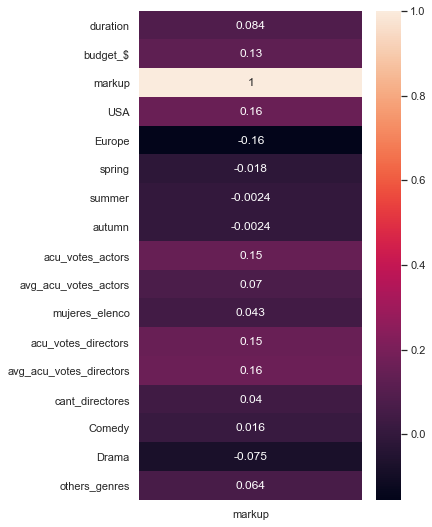

In [173]:
# Vemos la relación de nuestra target con las feautures
plt.figure(figsize=(5,9))
sns.heatmap(data.corr()[['markup']], annot=True)

#### Como podemos observar son 5 las features con mayor correlacion con la variable target, estas son: budget_$, USA, Europe, acu_votes_directors, avg_acu_votes_directors

<a id="section_target_final"></a>

## Discretización del Target

[volver a TOC](#section_toc)

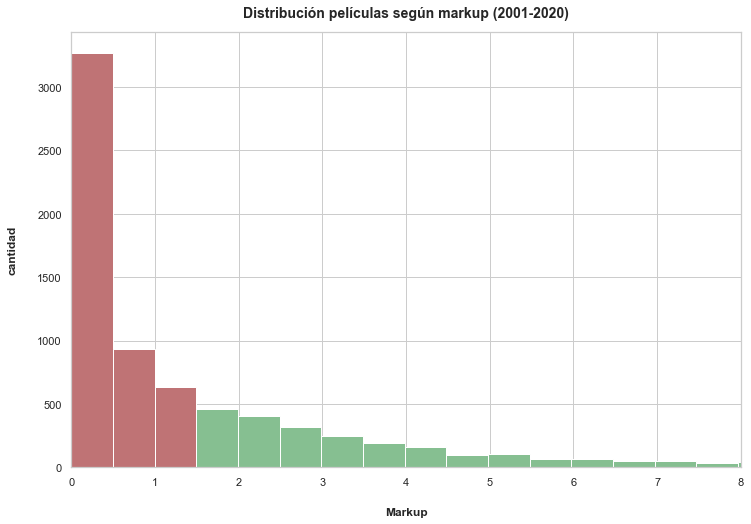

In [174]:
fig, ax = plt.subplots(figsize=(12,8))

N, bins, patches = ax.hist(data['markup'], bins=100, edgecolor='white', linewidth=1)

for i in range(0,3):
    patches[i].set_facecolor('#bf7375')
    
for i in range(3, len(patches)):
    patches[i].set_facecolor('#86bf91')

    
# Remove title
ax.set_title("Distribución películas según markup (2001-2020)", pad=15, weight='bold', size=14)

# Set x-axis label
ax.set_xlabel("Markup", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("cantidad", labelpad=20, weight='bold', size=12)
ax.figsize=(12,8)
plt.xlim(xmin=0, xmax =8)

plt.show()

#### . Los valores que estan en rojo son peliculas que sus ingresos no superaron sus costos
#### . Los valores verdes lograron un ROI (return on investment) superior al 50%

In [175]:
# Agregamos una nueva columna con los valores "mala inversion" o "buena inversion"
bins = (0, 1.5, 100)
group_labels = ['mala inversion', 'buena inversion']
A_categories_labels = pd.cut(data.markup, bins, right = True, include_lowest = True, labels = group_labels)
A_categories_labels.value_counts(normalize= True)

mala inversion     0.654548
buena inversion    0.345452
Name: markup, dtype: float64

In [176]:
# Agregamos la nueva columna al dataset
data['markup'] = A_categories_labels

In [177]:
dummies_markup= pd.get_dummies(data['markup'], drop_first=True)
dummies_markup.head()

,buena inversion
0,1
1,0
2,1
3,1
4,1


In [178]:
# Unimos los dataframes
data = pd.concat([data, dummies_markup], axis=1)
data.info ()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7399 entries, 0 to 7398
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   duration                 7399 non-null   int64   
 1   budget_$                 7399 non-null   float64 
 2   markup                   7399 non-null   category
 3   USA                      7399 non-null   uint8   
 4   Europe                   7399 non-null   uint8   
 5   spring                   7399 non-null   uint8   
 6   summer                   7399 non-null   uint8   
 7   autumn                   7399 non-null   uint8   
 8   acu_votes_actors         7399 non-null   float64 
 9   avg_acu_votes_actors     7399 non-null   float64 
 10  mujeres_elenco           7399 non-null   float64 
 11  acu_votes_directors      7399 non-null   float64 
 12  avg_acu_votes_directors  7399 non-null   float64 
 13  cant_directores          7399 non-null   int64   
 14  Comedy  

In [179]:
data= data.drop('markup',axis=1)

<a id="section_modelos"></a>

## Modelos de Clasificación Pipelines

[volver a TOC](#section_toc)

In [180]:
#Separamos las features y target en train y test.
X = data.drop(['buena inversion'], axis=1)
y = data['buena inversion']

X_train, X_test_final, y_train, y_test_final=train_test_split(X,y,test_size=0.3, random_state=159, stratify=y)

In [181]:
#Observamos que "mala inversion" en nuestra variable target ocupa el aprox el 70%, haciendo de este un problema con clases desbalanceadas.
y_train.value_counts(normalize=True)

0    0.654567
1    0.345433
Name: buena inversion, dtype: float64

<a id="section_smotenc"></a>

### SMOTENC

[volver a TOC](#section_toc)

In [182]:
#Como nuestro target esta desbalanceado procederemos a balancearlo haciendo un oversampling con SMOTENC.
smote=SMOTENC(categorical_features=[1, 2, 4, 5, 6, 7, 8],sampling_strategy='minority',random_state=159);

X_train_sm,y_train_sm = smote.fit_resample(X_train,y_train);


In [183]:
y_train_sm.value_counts()

0    3390
1    3390
Name: buena inversion, dtype: int64

In [184]:
y_test_final.value_counts()

0    1453
1     767
Name: buena inversion, dtype: int64

#### Vamos a correr modelos base como KNN o Regresión Logística, asi tambien modelos robustos como RandomForest o XGBoost.
#### El que nos arroje un mejor score lo utllizaremos con los datos de validación.

<a id="section_knn"></a>

### KNN

[volver a TOC](#section_toc)

In [185]:
folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

In [186]:
pipeline_1 = Pipeline([('scaler', StandardScaler()), 
                     ('knn', KNeighborsClassifier())])

parameters_1 = {'scaler':[StandardScaler(), MinMaxScaler(),None],
              'knn__n_neighbors':range(2,4,6),
              'knn__weights':['uniform','distance'],}

In [187]:
grid_1 = GridSearchCV(pipeline_1, parameters_1, cv=folds, scoring='precision')
grid_1.fit(X_train_sm,y_train_sm)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': range(2, 4, 6),
                         'knn__weights': ['uniform', 'distance'],
                         'scaler': [StandardScaler(), MinMaxScaler(), None]},
             scoring='precision')

In [188]:
print('Score: ',grid_1.best_score_)
grid_1.best_estimator_

Score:  0.7819251805109384


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=2))])

<a id="section_rl"></a>

### Regresión Logistica

[volver a TOC](#section_toc)

In [189]:
pipeline_2 = Pipeline([('scaler', StandardScaler()), 
                     ('log', LogisticRegression(solver='liblinear'))])

parameters_2 = {'scaler':[StandardScaler(), MinMaxScaler(),None],
              'log__penalty': ['l1', 'l2'],
              'log__C': [0.01, 0.1, 1, 10, 100],}

In [190]:
grid_2 = GridSearchCV(pipeline_2, parameters_2, cv=folds, scoring='precision')
grid_2.fit(X_train_sm,y_train_sm)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('log',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'log__C': [0.01, 0.1, 1, 10, 100],
                         'log__penalty': ['l1', 'l2'],
                         'scaler': [StandardScaler(), MinMaxScaler(), None]},
             scoring='precision')

In [191]:
print('Score: ',grid_2.best_score_)
grid_2.best_estimator_

Score:  0.7450336802504772


Pipeline(steps=[('scaler', None),
                ('log',
                 LogisticRegression(C=10, penalty='l1', solver='liblinear'))])

In [192]:
# Probamos modificando los valores de C
pipeline_3 = Pipeline([('scaler', StandardScaler()), 
                     ('log', LogisticRegression(solver='liblinear'))])

parameters_3 = {'scaler':[StandardScaler(), MinMaxScaler(),None],
              'log__penalty': ['l1', 'l2'],
              'log__C': [0.08, 0.09, 0.1, 0.11, 0.12],}


In [193]:
grid_3 = GridSearchCV(pipeline_3, parameters_3, cv=folds, scoring='precision')
grid_3.fit(X_train_sm,y_train_sm)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('log',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'log__C': [0.08, 0.09, 0.1, 0.11, 0.12],
                         'log__penalty': ['l1', 'l2'],
                         'scaler': [StandardScaler(), MinMaxScaler(), None]},
             scoring='precision')

In [194]:
print('Score: ',grid_3.best_score_)
grid_3.best_estimator_

Score:  0.7444716103107644


Pipeline(steps=[('scaler', StandardScaler()),
                ('log',
                 LogisticRegression(C=0.12, penalty='l1', solver='liblinear'))])

Pipeline + preprocesamiento + DecisionTrees

<a id="section_dt"></a>

### Decision Trees

[volver a TOC](#section_toc)

In [195]:
pipeline_4 = Pipeline([('scaler', StandardScaler()), 
                     ('tree',DecisionTreeClassifier(random_state=159))])

parameters_4 = {'scaler':[StandardScaler(), MinMaxScaler(),None],
              'tree__criterion': ['gini', 'entropy'],
              'tree__max_depth': [5, 25, 50, 75, 100],
             'tree__max_features': [5,10,15,20]}

In [196]:
grid_4 = GridSearchCV(pipeline_4, parameters_4, cv=folds, scoring='precision')
grid_4.fit(X_train_sm,y_train_sm)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=159))]),
             param_grid={'scaler': [StandardScaler(), MinMaxScaler(), None],
                         'tree__criterion': ['gini', 'entropy'],
                         'tree__max_depth': [5, 25, 50, 75, 100],
                         'tree__max_features': [5, 10, 15, 20]},
             scoring='precision')

In [197]:
print('Score: ',grid_4.best_score_)
grid_4.best_estimator_

Score:  0.7413436179873452


Pipeline(steps=[('scaler', StandardScaler()),
                ('tree',
                 DecisionTreeClassifier(max_depth=5, max_features=5,
                                        random_state=159))])

In [198]:
# Probamos con distintos valores de profudnidad y de features a utlizar.
pipeline_5 = Pipeline([('scaler', StandardScaler()), 
                     ('tree',DecisionTreeClassifier(random_state=159))])

parameters_5 = {'scaler':[StandardScaler(), MinMaxScaler(),None],
              'tree__criterion': ['gini', 'entropy'],
              'tree__max_depth': [35, 40, 50, 60, 65],
             'tree__max_features': [5, 7, 9, 11, 13, 15]}

In [199]:
grid_5 = GridSearchCV(pipeline_5, parameters_5, cv=folds, scoring='precision')
grid_5.fit(X_train_sm,y_train_sm)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=159))]),
             param_grid={'scaler': [StandardScaler(), MinMaxScaler(), None],
                         'tree__criterion': ['gini', 'entropy'],
                         'tree__max_depth': [35, 40, 50, 60, 65],
                         'tree__max_features': [5, 7, 9, 11, 13, 15]},
             scoring='precision')

In [200]:
# Vemos que vuelve a elegir los mismos hiperparámetros que antes
print('Score: ',grid_5.best_score_)
grid_5.best_estimator_

Score:  0.7188743953867004


Pipeline(steps=[('scaler', None),
                ('tree',
                 DecisionTreeClassifier(max_depth=35, max_features=9,
                                        random_state=159))])

<a id="section_random_forest"></a>

### Random Forest

[volver a TOC](#section_toc)

In [201]:
pipeline_6 = Pipeline([('scaler', StandardScaler()), 
                     ('RFC',RandomForestClassifier(random_state=159))])

parameters_6 = {'scaler':[StandardScaler(), MinMaxScaler(),None],
              'RFC__n_estimators': [200, 400, 600, 800],
              'RFC__max_samples': [0.3, 0.5, 0.7],
                'RFC__bootstrap':[True, False],
             'RFC__max_features': [10,12,14, 15, 17, 18, 20],
               'RFC__max_depth':[5, 10, 15]}

In [ ]:
random_search_1 = RandomizedSearchCV(pipeline_6, parameters_6, n_iter=50, cv=folds, scoring='precision', n_jobs=-1)
random_search_1.fit(X_train_sm, y_train_sm)

In [ ]:
print('Score: ',random_search_1.best_score_)
random_search_1.best_estimator_

In [ ]:
pipeline_7 = Pipeline([('scaler', StandardScaler()), 
                     ('RFC',RandomForestClassifier(random_state=159))])

parameters_7 = {'scaler':[StandardScaler(), MinMaxScaler(),None],
              'RFC__n_estimators': [100, 200, 300],
              'RFC__max_samples': [0.6, 0.7, 0.8],
                'RFC__bootstrap':[True, False],
             'RFC__max_features': [14, 15, 16],
               'RFC__max_depth':[15, 30]}

In [ ]:
grid_6 = GridSearchCV(pipeline_7, parameters_7, cv=folds, scoring='precision', n_jobs=-1)
grid_6.fit(X_train_sm,y_train_sm)

In [ ]:
print('Score: ',grid_6.best_score_)
grid_6.best_estimator_

<a id="section_xgb"></a>

### XGBoost

[volver a TOC](#section_toc)

In [203]:
pipeline_8 = Pipeline([('scaler', StandardScaler()), 
                     ('XGB',XGBClassifier(random_state=159))])
parameters_8 = {
    'XGB__n_estimators': [400,500,600],      # Number of boosted trees to fit.
    'XGB__max_depth': [4, 5, 6],            # Maximum tree depth for base learners.
    'XGB__learning_rate': [0.1, 0.2, 0.5],      # Boosting learning rate (xgb’s “eta”)
}

In [204]:
grid_8 = GridSearchCV(pipeline_8, parameters_8, cv=folds, scoring='precision', n_jobs=-1)
grid_8.fit(X_train_sm,y_train_sm)

[23:00:00] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('XGB',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_st...
                                                    

In [205]:
print('Score: ',grid_8.best_score_)
grid_8.best_estimator_

Score:  0.798826002897964


Pipeline(steps=[('scaler', StandardScaler()),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=400,
                               n_jobs=8, num_parallel_tree=1, random_state=159,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [206]:
#Correrla cuadno hayamos elegido el mejor modelo

# definimos una función para mostrar los resultados
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y); 
    
    plt.figure(figsize=(5, 3))
    sns.heatmap(conf_matrix,  annot=True, fmt="d");
    plt.title("Confusion matrix"); plt.ylabel('True class'); plt.xlabel('Predicted class')
    plt.show()

    print("METRICS")
    print (classification_report(y_test, pred_y))

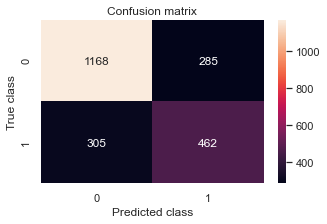

METRICS
              precision    recall  f1-score   support

           0       0.79      0.80      0.80      1453
           1       0.62      0.60      0.61       767

    accuracy                           0.73      2220
   macro avg       0.71      0.70      0.70      2220
weighted avg       0.73      0.73      0.73      2220



In [207]:
mostrar_resultados(y_test_final, grid_8.best_estimator_.predict(X_test_final))

#### LLegamos a una precision de 0.6 con nuestro mejor modelo, ahora probamos modificando el umbral teniendo en cuenta el trade-off Precision-Recall.

In [208]:
y_pred_proba_grid_8 = grid_8.best_estimator_.predict_proba(X_test_final)

In [209]:
y_probs_logit_left= y_pred_proba_grid_8[:,1]

In [210]:
y_pred_logit=(y_probs_logit_left > 0.77).astype(int)
y_pred_logit

array([0, 0, 1, ..., 0, 0, 0])

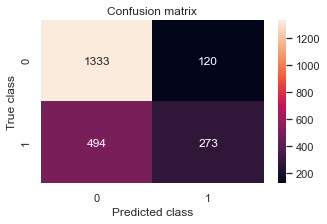

METRICS
              precision    recall  f1-score   support

           0       0.73      0.92      0.81      1453
           1       0.69      0.36      0.47       767

    accuracy                           0.72      2220
   macro avg       0.71      0.64      0.64      2220
weighted avg       0.72      0.72      0.69      2220



In [232]:
mostrar_resultados(y_test_final, y_pred_logit)

#### Consideramos optimo el aumento de la Precision hasta 0.7 a costa de una baja sensible en el Recall.
#### Ya que nos parece más importante que de las peliculas que el algoritmo clasifica como buena inversion, realmente lo sean.


<a id="section_rc_auc"></a>

### Roc Curve y AUC

[volver a TOC](#section_toc)

In [212]:
fpr_log,tpr_log,thr_log = roc_curve(y_test_final,grid_8.best_estimator_.predict_proba(X_test_final)[:,1])

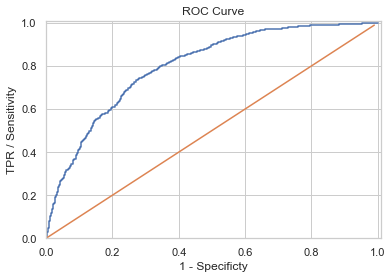

In [213]:
df = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty'); plt.ylabel('TPR / Sensitivity'); plt.title('ROC Curve')
plt.plot(df['fpr'],df['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

In [214]:
print('AUC=', auc(fpr_log, tpr_log))

AUC= 0.7996529232779189


<a id="section_rfe"></a>

### Recursive Feature Elimination with Cross Validation

[volver a TOC](#section_toc)

In [215]:
scaler= StandardScaler()
X_sc= scaler.fit_transform(X)

In [216]:
estimator =XGBClassifier(random_state=159,
                        n_estimators=600,
                        max_depth=6,
                        learning_rate=0.1,
                        eval_metric='mlogloss',
                        n_jobs=4)
kf = StratifiedKFold(n_splits = 5, shuffle = True)

rfecv = RFECV(estimator, cv=kf, step = 1)
rfecv.fit(X_sc, y)

scores = pd.DataFrame()
scores["Attribute Name"] = X.columns; scores["Ranking"] = rfecv.ranking_; scores["Support"] = rfecv.support_

print(scores.sort_values('Ranking'))


             Attribute Name  Ranking  Support
0                  duration        1     True
1                  budget_$        1     True
2                       USA        1     True
3                    Europe        1     True
4                    spring        1     True
6                    autumn        1     True
7          acu_votes_actors        1     True
8      avg_acu_votes_actors        1     True
9            mujeres_elenco        1     True
10      acu_votes_directors        1     True
11  avg_acu_votes_directors        1     True
12          cant_directores        1     True
13                   Comedy        1     True
14                    Drama        1     True
15            others_genres        1     True
5                    summer        2    False


#### Habiendo hecho recursive feature elimination con cross validation, el algoritmo concluyó que todas las features deben participar en el modelo.

<a id="section_pickle"></a>

## Pickle

[volver a TOC](#section_toc)

In [249]:
with open('../modelo_entrenado.pkl', 'wb') as modelo_entrenado:
    pickle.dump(grid_8.best_estimator_, modelo_entrenado)

In [250]:
with open('../modelo_entrenado.pkl', 'rb') as modelo_entrenado:
    modelo_entrenado_from_disk = pickle.load(modelo_entrenado)

In [251]:
display(modelo_entrenado_from_disk)

Pipeline(steps=[('scaler', StandardScaler()),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=400,
                               n_jobs=8, num_parallel_tree=1, random_state=159,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])